In [1]:
import os
import sys
import time as t_util
import numpy as np
import cftime
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import mplotutils as mpu
import pandas as pd
from scipy.stats import linregress


In [2]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main  = file.read()

dir_EMT_CORDEX = f'{path_main}Data/EURO-CORDEX/EMT/'
dir_data       = f'{path_main}Data/'
dir_names      = f'{path_main}Scripts/Model_lists/'
dir_fig        = f'{path_main}Figures/Paper_v2/'
dir_repo       = f'{path_main}Data/RepositoryPublication/'


## Prepare data

In [3]:
#Define models and RCPs which should be used
models_CORDEX = dict()
models_CORDEX = []
with open(dir_names + 'Models_CORDEX-EUR-11_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        models_CORDEX.append(eval(line[:-1]))

#Define models and RCPs which should be used
models_CMIP5 = dict()
models_CMIP5 = []
with open(dir_names + 'Models_CMIP5_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        models_CMIP5.append(line[:-1])
      
    
    
models_CMIP5 = models_CMIP5[0:-1]    
    
    
    
    
    
    
    
#Define models and RCPs which should be used
models_CMIP6 = dict()
models_CMIP6 = []
with open(dir_names + 'Models_CMIP6_SSP585.txt', 'r') as filehandle:
    for line in filehandle:
        models_CMIP6.append(line[:-1])        
        
models_set = dict()
models_set['CMIP6']       = models_CMIP6  
models_set['CMIP5']       = models_CMIP5
models_set['EURO-CORDEX'] = models_CORDEX

colors = dict()
colors['EURO-CORDEX'] = 'tab:red'
colors['CMIP5']       = 'darkorchid'
colors['CMIP6']       = 'k'  

dEMT = 3


## Extract CMIP models used in EURO-CORDEX

In [4]:
#Count occurrence of CORDEX GCMs
GCMs_COR_orig = [model[0] + '_' + model[2] for model in models_CORDEX]

GCMs_CORDEX = []
for GCM in GCMs_COR_orig:
    
    if 'MPI' in GCM or 'CNRM' in GCM:  GCMs_CORDEX.append("-".join(GCM.split('-')[2::]))
    else:                              GCMs_CORDEX.append("-".join(GCM.split('-')[1::]))

GCMs_unique = list(set(GCMs_CORDEX))
counts_GCMs = {GCM:GCMs_CORDEX.count(GCM) for GCM in GCMs_unique}


## Get EMT and GMT change for CMIP5 and CMIP6

In [5]:
#Define reference period
ref_per = slice('1981', '2010')

#Create dict for storing data and for creating output dataframe
data_dict     = dict()
data_coll_out = dict()

#Loop over CMIP5, CMIP6, CORDEX
p_all = []
for model_set, models in models_set.items():

    #Define scenarios
    if model_set=='EURO-CORDEX':  continue
    elif model_set=='CMIP6':      scen_fut = 'ssp585'
    elif model_set=='CMIP5':      scen_fut = 'rcp85'

    #Define scenarios
    scenarios = ['historical', scen_fut]
    
    #Loop over GMT and EMT
    for T_sel in ['GMT', 'EMT']:

        #Define folder
        dir_read = dir_data + model_set + '/' + T_sel + '/'
    
        #Loop over all models
        model_names = []
        data_coll_out2 = pd.DataFrame(columns=models)
        for i, model in enumerate(models):

            #Define members for CMIP5
            if model_set=='CMIP5':
                if model=='EC-EARTH':      members = ['r1i1p1', 'r12i1p1']
                elif model=='MPI-ESM-LR':  members = ['r1i1p1', 'r2i1p1', 'r3i1p1']
                else:                      members = ['r1i1p1']        
            else:
                members = ['']
                
            #Loop over members
            for member in members:

                if model_set=='CMIP5':
                    model_names.append( model + '_' + member)
                else:
                    model_names.append( model)
                
                #Loop over scenarios
                for scen in scenarios:

                    #Get file names
                    fnames_hist = [file for file in os.listdir(dir_read) if T_sel + '_' in file and model + '_' in file and member in file and 'historical' in file]
                    fnames_rcp  = [file for file in os.listdir(dir_read) if T_sel + '_' in file and model + '_' in file and member in file and scen_fut in file]
                    if len(fnames_hist)>1:
                        fnames_hist = [fname for fname in fnames_hist if int(fname.split('_')[-1].split('-')[0])>1900]
                    if len(fnames_hist)!=1:  sys.exit('File is not unique')
                    if len(fnames_rcp)!=1:   sys.exit('File is not unique')

                    #Read and concatenate data
                    fnames = fnames_hist + fnames_rcp
                    data_read = xr.concat((xr.open_dataset(dir_read + fname, use_cftime=True) for fname in fnames), dim='time')

                #Drop height
                if 'height' in data_read:  data_read = data_read.drop('height')                    
                    
                #Collect data for saving in excel file
                data_pd = data_read.copy()
                data_pd['time'] = data_pd.time.dt.year
                data_coll_out2[model] = data_pd.tas.to_dataframe()['tas']

                #Calculate change w.r.t. reference period
                data_rel = data_read - data_read.sel(time=ref_per).mean()

                #Smooth data
                data_rel_smooth = data_rel.rolling(time=10, center=True).mean('time')

                #Concatenate data
                if i==0:
                    data_coll = data_rel_smooth
                else:
                    data_rel_smooth['time'] = data_coll.time
                    data_coll = xr.concat((data_coll, data_rel_smooth), dim='model')

        #Add model names and save in dict
        data_coll['model'] = model_names
        data_dict[T_sel + '_' + model_set]     = data_coll
        data_coll_out[T_sel + '_' + model_set] = data_coll_out2
        

## Calculate global warming since PI

In [6]:
#Define reference period
ref_per = slice('1850', '1900')

#Create dict for storing data 
data_GlobWarm = dict()

#Loop over CMIP5, CMIP6, CORDEX
p_all = []
for model_set, models in models_set.items():
    
    if model_set=='EURO-CORDEX':  continue    
    
    #Define folder
    dir_read = dir_data + model_set + '/GMT/'

    array_coll = np.zeros(len(models)) * np.NaN
    
    #Loop over all models
    for i, model in enumerate(models):        

        #Define members for CMIP5
        if model_set=='CMIP5':
            member = 'r1i1p1'
        else:
            member = ''

        #Get file names
        fnames_hist = [file for file in os.listdir(dir_read) if 'GMT_' in file and model + '_' in file and member in file and 'historical' in file]
        if len(fnames_hist)>1:
            fnames_hist = [fname for fname in fnames_hist if int(fname.split('_')[-1].split('-')[0])<1900]
        if len(fnames_hist)!=1:  sys.exit('File is not unique')

        #Read data
        data_read = xr.open_dataset(dir_read + fnames_hist[0], use_cftime=True)

        #Calculate change w.r.t. reference period
        data_rel = data_read - data_read.sel(time=ref_per).mean()
        data_rel = data_rel.sel(time=slice('1981', '2010')).mean()
        
        
        array_coll[i] = data_rel.tas.item()
            
    #Add model names and save in dict
    print('Global warming up to 1981-2010 for ' + model_set, end=': ')
    print('{:.2f}'.format(array_coll.mean()) + '°C')
    data_GlobWarm['GMT_' + model_set] = array_coll
    

Global warming up to 1981-2010 for CMIP6: 0.58°C
Global warming up to 1981-2010 for CMIP5: 0.61°C


## Interpolate CMIP5 and CMIP6 GMT and EMT data

In [7]:
#Define target x vector
x = np.arange(-1, 7, 0.1)
y_plot = dict()

#Loop over model sets
for model_set, models in models_set.items():

    if model_set=='EURO-CORDEX':  continue    
    
    #Get data
    GMT = data_dict['GMT_' + model_set]
    EMT = data_dict['EMT_' + model_set]

    #Array for storing data
    y_all = np.zeros((len(x), len(GMT.model))) * np.NaN
    
    #Loop over models
    for i0, model in enumerate(GMT.model):
    
        #Get data
        xp = GMT.sel(model=model).tas
        yp = EMT.sel(model=model).tas
        
        #Interpolate and save in array
        y_all[:, i0] = np.interp(x, xp, yp)
    
    #Calculate quantiles and store in dict
    y_plot[model_set + '_Q10'] = np.nanquantile(y_all, 0.10, axis=1)
    y_plot[model_set + '_Q25'] = np.nanquantile(y_all, 0.25, axis=1)
    y_plot[model_set + '_Q50'] = np.nanquantile(y_all, 0.50, axis=1)
    y_plot[model_set + '_Q75'] = np.nanquantile(y_all, 0.75, axis=1)
    y_plot[model_set + '_Q90'] = np.nanquantile(y_all, 0.90, axis=1)
    

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


## Plot

Skip EC-EARTH for central year
Skip EC-EARTH for central year
Skip MIROC5 for central year
Skip MPI-ESM-LR for central year
Skip MPI-ESM-LR for central year
Skip MPI-ESM-LR for central year
dGMT(dEMT=3°C) in CMIP6: 2.4 (2.6 to 2.3, IQR)
dGMT(dEMT=3°C) in CMIP5: 2.5 (2.8 to 2.4, IQR)


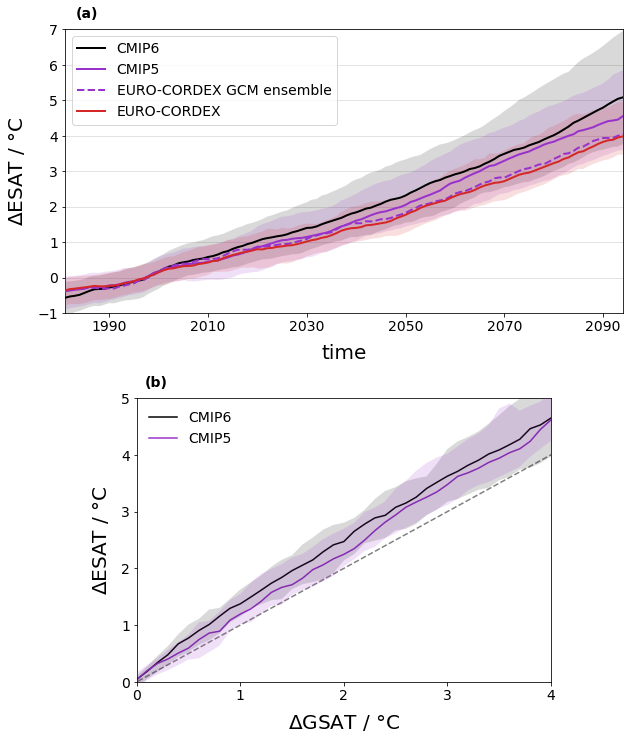

In [8]:
#Define reference period
ref_per = slice('1981', '2010')

#Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.3)


### Plot EMT ###

ax = axes[0]

#Empty dict for collecting data
coll_years = dict()

#Loop over CMIP5, CMIP6, CORDEX
p_all = []
for model_set, models in models_set.items():
    
    dir_EMT = dir_data + model_set + '/EMT/'
    
    coll_years[model_set] = np.zeros(len(models)) * np.NaN
    
    if model_set=='EURO-CORDEX':
        data_coll_out3 = pd.DataFrame(columns=["_".join(model) for model in models])

    #Loop over all CORDEX models
    model_names = []
    for i, model in enumerate(models):
        
        if model_set=='EURO-CORDEX':
            mod_read = "_".join(model)
        else:
            mod_read = model + '_'
        
        #Select scenarios
        if model_set=='CMIP6':  scen_fut = 'ssp585'
        else:                   scen_fut = 'rcp85'
        
        scenarios = ['historical', scen_fut]
        
        #Define members for CMIP5
        if model_set=='CMIP5':
            if model=='EC-EARTH':      members = ['r1i1p1', 'r12i1p1']
            elif model=='MPI-ESM-LR':  members = ['r1i1p1', 'r2i1p1', 'r3i1p1']
            else:                      members = ['r1i1p1']        
        else:
            members = ['']     

        #Loop over members
        for member in members:

            #Define model names
            if model_set=='CMIP5':  model_names.append(model + '_' + member)
            else:                   model_names.append(mod_read[0::])                        
            
            #Loop over scenarios
            for scen in scenarios:

                #Get file names
                fnames_hist = [file for file in os.listdir(dir_EMT) if 'EMT_' in file and mod_read in file and member in file and 'historical' in file]
                fnames_rcp = [file for file in os.listdir(dir_EMT) if 'EMT_' in file and mod_read in file and member in file and scen_fut in file]
                if len(fnames_hist)!=1:  sys.exit('File is not unique')
                if len(fnames_rcp)!=1:  sys.exit('File is not unique')

                #Read and concatenate EMT
                fnames = fnames_hist + fnames_rcp
                data_EMT = xr.concat((xr.open_dataset(dir_EMT + fname, use_cftime=True) for fname in fnames), dim='time')

                #Select in time window and collect data in dataframe
                if model_set=='EURO-CORDEX':
                    data_EMT = data_EMT.sel(time=slice('1971', '2100'))
                    
                    #Collect data for saving in excel file
                    data_pd = data_EMT.copy()
                    data_pd['time'] = data_pd.time.dt.year
                    data_coll_out3["_".join(model)] = data_pd.tas.to_dataframe()['tas']
                    
            #Calculate change w.r.t. reference period
            data_EMT_rel = data_EMT - data_EMT.sel(time=ref_per).mean()

            #Select data in common period
            if model_set=='EURO-CORDEX':
                data_EMT_rel = data_EMT_rel.sel(time=slice('1971', '2098'))

            #Drop height
            if 'height' in data_EMT_rel: data_EMT_rel = data_EMT_rel.drop('height')

            #Smooth data and find year in which a certain EMT value is exceeded for the first time
            data_EMT_smooth = data_EMT_rel.rolling(time=20, center=True).mean('time')
            ind = np.where(data_EMT_smooth.tas>dEMT)[0]
            if len(ind)!=0:
                central_year = data_EMT_smooth.isel(time=ind[0]).time.dt.year

                if (model_set=='CMIP5' and model in ['EC-EARTH', 'MIROC5', 'MPI-ESM-LR']):
                    print('Skip ' + model + ' for central year')
                else:
                    coll_years[model_set][i] = central_year
            else:
                print(mod_read)

            #Concatenate data
            if i==0:
                data_EMT_coll = data_EMT_rel
            else:
                data_EMT_rel['time'] = data_EMT_coll.time
                data_EMT_coll = xr.concat((data_EMT_coll, data_EMT_rel), dim='model')
    
    #Add model names to data array
    data_EMT_coll['model'] = model_names
    
    #Collect dat for saving in excel file
    if model_set=='EURO-CORDEX':
        data_coll_out['EMT_EURO-CORDEX'] = data_coll_out3
    
    #Calculate weighted average for CMIP5 models (to match the EURO-CORDEX GCM ensemble)
    if model_set=='CMIP5':
        
        #Loop over GCMs used in CORDEX
        create = 1
        for GCM, N in counts_GCMs.items():
            
            #Replace r3i1p1 member of EC-EARTH with a different member, as no data exits for it
            if GCM=='EC-EARTH_r3i1p1':  GCM = 'EC-EARTH_r1i1p1'            

            #Select GCM and add it N times to arrray
            data_sel = data_EMT_coll.sel(model=GCM)
            for n in range(0, N):
                if create==1:
                    data_CMIP5_weighted = data_sel
                    create = 0
                else:
                    data_CMIP5_weighted = xr.concat((data_CMIP5_weighted, data_sel), dim='N')
        
        #Calculate model average and moving average
        data_CMIP5_weighted = data_CMIP5_weighted.median('N')
        data_CMIP5_weighted = data_CMIP5_weighted.rolling(time=10, center=True).mean('time')
        
        #Select only one ensemble member per model
        models_sel = [model for model in data_EMT_coll.model.values if 'r1i1p1' in model]
        data_EMT_coll = data_EMT_coll.sel(model=models_sel)
        
    #Calculate multi-model median
    data_Q10 = data_EMT_coll.quantile(0.1, 'model')
    data_Q50 = data_EMT_coll.quantile(0.5, 'model')
    data_Q90 = data_EMT_coll.quantile(0.9, 'model')

    #Moving average
    data_Q10 = data_Q10.rolling(time=10, center=True).mean('time')
    data_Q50 = data_Q50.rolling(time=10, center=True).mean('time')
    data_Q90 = data_Q90.rolling(time=10, center=True).mean('time')

    ax.fill_between(data_Q10.time.dt.year, data_Q10.tas, data_Q90.tas, color=colors[model_set], edgecolor='none', alpha=0.15, zorder=10)

    #Plot multi-model median
    p = ax.plot(data_Q50.time.dt.year, data_Q50.tas, linewidth=2, color=colors[model_set], alpha=1, zorder=20, label=model_set)    
    p_all.append(p[0])
    
    if model_set=='CMIP5':
        p_extra = ax.plot(data_CMIP5_weighted.time.dt.year, data_CMIP5_weighted.tas, linewidth=2, linestyle='--', color=colors[model_set], alpha=1, zorder=20, label='EURO-CORDEX GCM ensemble')

#Limits, labels, and ticks    
xlims = [1981, 2094]
ylims = [-1, 7]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xticks(range(1990, 2100, 20))
ax.set_xlabel('time', fontsize=20, labelpad=10)
ax.set_ylabel('$\Delta$ESAT / °C', fontsize=20, labelpad=10)
# ax.set_title('Change in European mean temperature', fontsize=20, pad=15)
ax.tick_params(labelsize=14)

#Legend
ax.legend(loc=2, fontsize=14)

#Gridlines
ax.yaxis.grid(color='gainsboro')

#Write letter
ax.text(xlims[0] + 0.02 * np.diff(xlims), ylims[0] + 1.03 * np.diff(ylims), '(a)', va='bottom', ha='left', fontweight='bold', fontsize=14)



### EMT-GMT plot ####

ax = axes[1]

x_text = [0.6, 0.6]
y_text = [3.3, 2.9]
    
#Loop over model sets  
p_all = []
for ii, (model_set, models) in enumerate(models_set.items()):

    if model_set=='EURO-CORDEX':  continue
    
    #Get data
    y_Q10 = y_plot[model_set + '_Q10']
    y_Q50 = y_plot[model_set + '_Q50']
    y_Q90 = y_plot[model_set + '_Q90']
    
    #Plot
    ax.fill_between(x, y_Q10, y_Q90, color=colors[model_set], edgecolor='none', alpha=0.15, zorder=10)
    p = ax.plot(x, y_Q50, color=colors[model_set])
    p_all.append(p[0])
    
#     #Calculate slope of median
#     x_reg = x[~np.isnan(y_Q50)]
#     y_reg = y_Q50[~np.isnan(y_Q50)]
#     regr  = linregress(x_reg, y_reg)
    
#     #Show slope in figures
#     text = r'$\frac{\partial \mathrm{EMT}}{\partial \mathrm{GMT}}$' + ' = ' + '{:.2f}'.format(regr.slope) + ' °C/°C'
#     ax.text(x_text[ii], y_text[ii], text, fontsize=14, color=colors[model_set])
    
    #Print warming in CMIP models at 3°C European warming
    Q25 = y_plot[model_set + '_Q25']
    Q50 = y_plot[model_set + '_Q50']
    Q75 = y_plot[model_set + '_Q75']
    print('dGMT(dEMT=3°C) in ' + model_set , end=': ')
    print(np.round(x[np.nanargmin(np.abs(Q50 - 3))], 2), end = ' (')
    print(np.round(x[np.nanargmin(np.abs(Q25 - 3))], 2), end=' to ')
    print(np.round(x[np.nanargmin(np.abs(Q75 - 3))], 2), end=', IQR)')
    print('')

    
#Plot one-to-one line
ax.plot([-1, 6], [-1, 6], linestyle='--', color='gray', zorder=5)

#Limits, labels, and ticks
xlims = [0, 4]
ylims = [0, 5]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xticks(np.arange(0, 5))
ax.set_xlabel('$\Delta$GSAT / °C', fontsize=20, labelpad=10)
ax.set_ylabel('$\Delta$ESAT / °C', fontsize=20, labelpad=10)
ax.tick_params(labelsize=14)

#Legend
ax.legend(p_all, list(models_set.keys()), frameon=False, loc=2, fontsize=14)

#Change size of lower axes
pos = ax.get_position()
pos.x0 = pos.x0 + 0.10
pos.x1 = pos.x1 - 0.10
ax.set_position(pos)

#Write letter
ax.text(xlims[0] + 0.02 * np.diff(xlims), ylims[0] + 1.03 * np.diff(ylims), '(b)', va='bottom', ha='left', fontweight='bold', fontsize=14)

#Save figure
fig.savefig(dir_fig + 'Fig2_ESAT_GSAT.png', bbox_inches='tight', dpi=300)


## Export data to excel

In [9]:
#Define names for output
T_out = dict()
T_out['GMT'] = 'GSAT'
T_out['EMT'] = 'ESAT'

#Define output file name
fname_out = dir_repo + 'Data_Fig2_timeseries-GSAT-ESAT_EURO-CORDEX_CMIP5_CMIP6_1971-2100_RCP85_SSP585.xlsx'
if os.path.exists(fname_out):  os.remove(fname_out)

#Create excel file
with pd.ExcelWriter(fname_out, mode="w") as writer:

    #Loop over model sets
    for model_set in models_set:

        #Loop over GSAT & EMT
        for T_sel in ['GMT', 'EMT']:

            #Skip non-existing data for EURO-CORDEX
            if model_set=='EURO-CORDEX' and T_sel=='GMT':
                continue

            #Select data
            data = data_coll_out[T_sel + '_' + model_set]

            #Select data between 1971-2100
            data = data.loc[slice(1971, 2100)]
            
            #Add unit
            data.index = data.index.rename('unit: K')
            data.columns = data.columns.rename('')

            #Save in file
            data.to_excel(writer, sheet_name=f'{T_sel} {model_set}', float_format="%.2f")
